# Neural Network - Multi-layer Perceptron (MLP)

Example of simple 3-layer feed-forward neural network for binary classification.

$$\mathbf{h} = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$$
$$p(C_1|\mathbf{x}) = \sigma(\mathbf{W}_2 \mathbf{h} + b_2)$$

Note that, since we have only a single output, the matrix $\mathbf{W}_2$ has only a single row. To simplify the notation and the implementation, we define

$$\hat{\mathbf{x}} = \begin{bmatrix} 1 \\ \mathbf{x} \end{bmatrix}$$
$$\hat{\mathbf{h}} = \begin{bmatrix} 1 \\ \mathbf{h} \end{bmatrix}$$
$$\hat{\mathbf{W}}_1 = [\mathbf{b}_1 \mathbf{W}_1]$$
$$\hat{\mathbf{W}}_2 = [b_2 \mathbf{W}_2]$$

and revwrite the neural network deffinition as
$$\mathbf{a}_1 = \hat{\mathbf{W}}_1 \hat{\mathbf{x}}$$
$$\mathbf{h} = \sigma(\mathbf{a}_1)$$
$$a_2 = \hat{\mathbf{W}}_2 \hat{\mathbf{h}}$$
$$p(C_1|\mathbf{x}) = y = \sigma(a_2)$$

Training is done using Stochastic Gradient descent (SGD) updating weights for every training example

$$\mathbf{w}^{new} = \mathbf{w}^{old} - \eta \nabla E(\mathbf{w}^{old})$$

where $\mathbf{w}^{old}$ is vector representation of all current parameters $\{\hat{\mathbf{W}}_1, \hat{\mathbf{W}}_2 \}$ and $\nabla E$ is the gradient of the cross-entropy objective evaluated one (each) training example

$$E(\mathbf{w}) = - t  \lnâĄ y - (1ât)\ln(1ây)$$

The elements of the gradient can be calculated using the following derivatives

$$\frac{\partial E}{\partial a_2} = \frac{\partial E}{\partial y}\frac{\partial y}{\partial a_2}
= \frac{\partial (-t\lnâĄ y-(1ât)\ln(1ây))}{\partial y} \frac{\partial \sigma(a_2)}{\partial a_2}
= \left(\frac{1-t}{1-y}-\frac{t}{y}\right)(y(1-y))
= y-t$$

$$\frac{\partial E}{\partial a_{1i}}
= \frac{\partial E}{\partial a_2} \frac{\partial a_2}{\partial h_i}\frac{\partial h_i}{\partial a_{1i}}
= \frac{\partial E}{\partial a_2}(W_{2i})(h_i(1-h_i))$$

$$\frac{\partial E}{\partial \mathbf{a}_1}
= \frac{\partial E}{\partial a_2} \mathbf{W}_2\circ \mathbf{h}^T \circ(1-\mathbf{h}^T)$$
where \circ is element-wise product

$$\frac{\partial E}{\partial \hat{\mathbf{W}}_2}
= \frac{\partial E}{\partial a_2}\frac{\partial a_2}{\partial \hat{\mathbf{W}}_2}
= \frac{\partial E}{\partial a_2} \frac{\partial \hat{\mathbf{W}}_2 \hat{\mathbf{h}}}{\partial \hat{\mathbf{W}}_2}
= \frac{\partial E}{\partial a_2} \hat{\mathbf{h}}^T
$$

$$\frac{\partial E}{\partial \hat{W}_{1ij}}
= \frac{\partial E}{\partial a_{1i}}\frac{\partial a_{1i}}{\partial \hat{W}_{1ij}}
= \frac{\partial E}{\partial a_{1i}}\hat{x}_j
$$

$$\frac{\partial E}{\partial \hat{\mathbf{W}}_1}
= \left(\hat{\mathbf{x}} \frac{\partial E}{\partial \mathbf{a}_1}\right) ^T$$

In [56]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})
import numpy as np
from IPython.display import clear_output
from numpy.random import randn


def logistic_sigmoid(a):
    return 1 / (1 + np.exp(-a))
      
def eval_nnet(x, w1, w2):
    """
    Propagate data through the neural network binary classifier

    - X are the input features, datapoints are stored column-wise
    - W1 weights of 1st layer (first column contain bias)
    - W2 weights of 2nd layer (first column contain bias)

    Returns the network outputs (single dimensional)
    """
    h = logistic_sigmoid(np.c_[np.ones(len(x)), x].dot(w1))
    return logistic_sigmoid(np.c_[np.ones(len(h)), h].dot(w2))

def train_nnet(X, T, w1, w2, epsilon):
    """
    SGD training of the neural network parameters. Only binary
    classifier with single hidden layer is considered for the simplicity.
    """
    mixer = np.random.permutation(len(X))
    X = X[mixer]
    T = T[mixer]
    ed = 0
    for x, t in zip(X, T):
        h = logistic_sigmoid(np.r_[1, x].dot(w1))
        y = logistic_sigmoid(np.r_[1, h].dot(w2))

        de_da2 = y - t
        de_da1 = de_da2 * w2[1:].T * h * (1 - h)

        w1 -= epsilon * np.r_[1, x][:,np.newaxis].dot(de_da1) # SGD updates of weights in the first ...
        w2 -= epsilon * np.r_[1, h][:,np.newaxis] * de_da2    # and the second layer
        ed -= t * np.log(y) + (1 - t) * np.log(1 - y)
    return (w1, w2, ed)

def plot2dfun(f, limits, resolution, ax=None):
    if ax is None:
        ax = plt
    xmin, xmax, ymin, ymax = limits
    xlim = np.arange(ymin, ymax, (ymax - ymin) / float(resolution))
    ylim = np.arange(xmin, xmax, (xmax - xmin) / float(resolution))
    a, b = np.meshgrid(ylim, xlim)
    img = f(np.vstack([np.ravel(a), np.ravel(b)[::-1]]).T)
    img = (img - img.min()) /(img.max() - img.min()) # normalize to range 0.0 - 1.0
    img = img.reshape(a.shape+img.shape[1:])
    ax.imshow(img, cmap='gray', aspect='auto', extent=(xmin, xmax, ymin, ymax))
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)

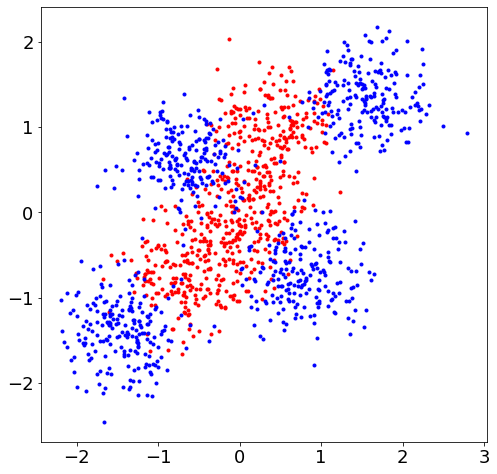

In [57]:
# Create some training data for two classes
n = 200
x1 = np.r_[randn(n, 2) + np.array([1, 3]),
           randn(n, 2) + np.array([-2, -2]),
           randn(n, 2) + np.array([0, 0])]
x2 = np.r_[randn(n, 2) + np.array([-2, 2]),
           randn(n, 2) + np.array([2, -2]),
           randn(n, 2) + np.array([4, 4]),
           randn(n, 2) + np.array([-4, -4])]

#Create 1/0 labels for the training data
t1 = np.ones(len(x1))
t2 = np.zeros(len(x2))

# Mean and variance normalize the training data to make the training easier
mu = np.mean(np.r_[x1, x2], axis=0)
sig = np.std(np.r_[x1, x2], axis=0)

x1 = (x1 - mu) / sig
x2 = (x2 - mu) / sig

x = np.r_[x1, x2]
t = np.r_[t1, t2]

#Plot the training data
plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
ax = plt.axis()
plt.show()

# Initialize parameter of the neural network
dim_in     = 2 # The input data are 2-dimension, so that we can plot them
dim_hidden = 10 # Hidden layer size
dim_out    = 1 # We consider only only binary classification here, so the output dimension is 1

w1 = randn(dim_in + 1, dim_hidden)  * .1 # Initial parameter for the first ...
w2 = randn(dim_hidden + 1, dim_out) * .1 # ... and the second layer

epsilon = .1 # learnoing rate
xentropy=[] # Here, we will store cross-entropy on the training data over the trainig iterations

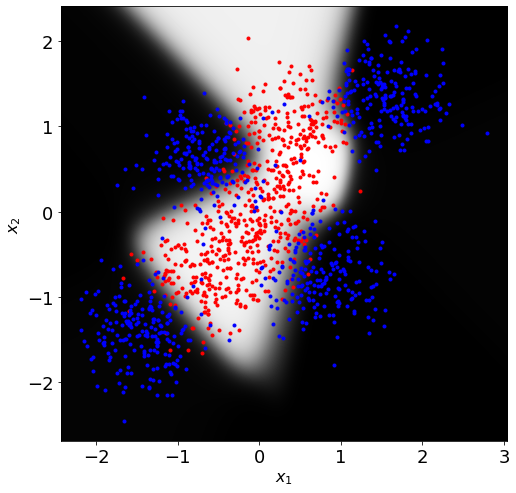

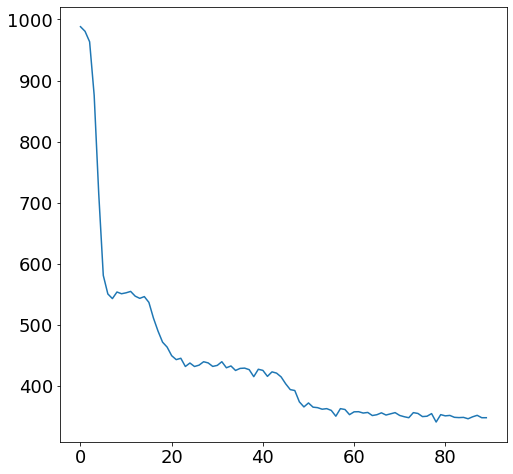

In [60]:
for i in range(30):
    clear_output(wait=True)
    plot2dfun(lambda x: eval_nnet(x, w1, w2), ax, 500)
    plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
    plt.show()

    w1, w2, ed = train_nnet(x, t, w1, w2, epsilon)
    xentropy.append(ed)
plt.plot(xentropy)

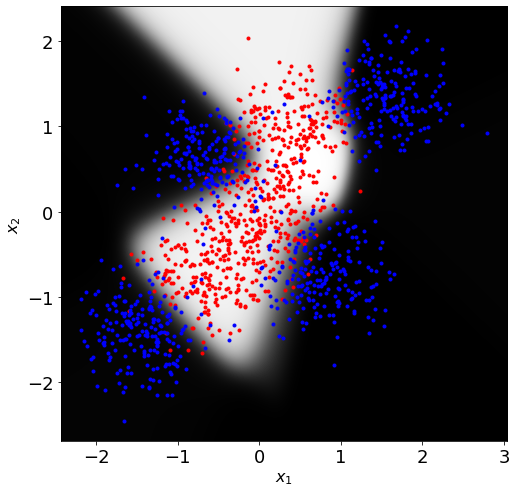

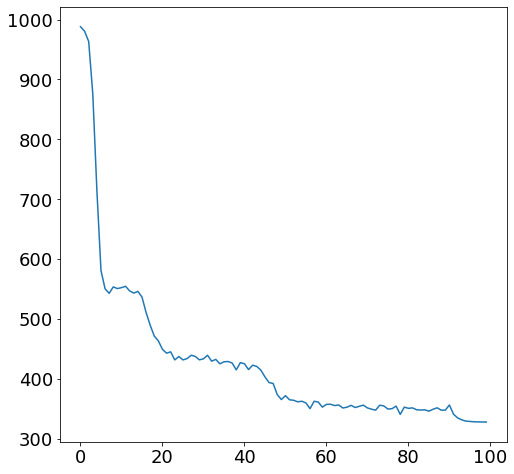

In [61]:
# Continue training while halving the learning rate in every epoch
for i in range(10):
    clear_output(wait=True)
    plot2dfun(lambda x: eval_nnet(x, w1, w2), ax, 500)
    plt.plot(x1[:,0], x1[:,1], 'r.', x2[:,0], x2[:,1], 'b.')
    plt.show()

    w1, w2, ed = train_nnet(x, t, w1, w2, epsilon)
    xentropy.append(ed)
    epsilon *= 0.5 # halving learning rate in each iteration
plt.plot(xentropy)